In [6]:
import os, sys, glob
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from sklearn.metrics import precision_score, recall_score
from transformers import BertForSequenceClassification, BertTokenizerFast, BertJapaneseTokenizer, Trainer, TrainingArguments
from transformers import pipeline, Pipeline
from datasets import load_dataset, Dataset

pd.options.display.float_format = "{:.4f}".format

id2tag = pd.read_csv('data/カテゴリー・タグ定義.csv', encoding='cp932')['タグ'].to_dict()
tag2id = {v:k for k, v in id2tag.items()}

In [11]:
def load_assets(model_path:str) -> Tuple[Trainer, Dataset]:
  """モデルとデータセットを読み込む
  """
  # tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-v3')
  tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-large-japanese-v2')
  dataset = load_dataset('dataset_loader.py', name='category_tagging')

  def _tokenize(batch):
      return tokenizer(batch['text'], padding='max_length', truncation=True)

  # データセットを準備する
  eval_dataset =  dataset['validation'].map(_tokenize, batched=True)
  eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

  # モデルを読み込む
  model = BertForSequenceClassification.from_pretrained(model_path, num_labels=len(id2tag), id2label=id2tag, label2id=tag2id)
  trainer = Trainer(
      model=model
  )
  return trainer, eval_dataset

def predict(sentiment_analyzer:Pipeline, eval_dataset:Dataset) -> Dict[np.ndarray, np.ndarray]:
# def predict(trainer:Trainer, eval_dataset:Dataset) -> Dict[np.ndarray, np.ndarray]:
  # metricsを計算する
  # print(trainer.evaluate(eval_dataset))
  # 予測する
  predictions = sentiment_analyzer.predict(eval_dataset)
  return {'predict_proba':predictions.predictions, 'labels':np.argmax(predictions.predictions, axis=1)}

def evaluate(y_true, y_pred, method='macro', verbose=True):
  accuracy = np.mean(y_true == y_pred)
  precision_macro = precision_score(y_true, y_pred, average=method)
  recall_macro = recall_score(y_true, y_pred, average=method)
  f1 = 2 * (precision_macro * recall_macro) / (precision_macro + recall_macro)
  if verbose:
    print(f'accuracy: {accuracy:.3f}\nprecision_macro: {precision_macro:.3f}\nrecall_macro: {recall_macro:.3f}\nf1: {f1:.3f}')
    display(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
  return precision_macro, recall_macro, f1

def calculate_f1_score(model_name: str, eval_df: pd.DataFrame):
  prefix = model_name.split('/')[-1]
  prediction_results = predict(*load_assets(model_name))
  eval_df[f'pred_{prefix}'] = prediction_results['labels']
  _, _, f1 = evaluate(eval_df['label'], eval_df[f'pred_{prefix}'])
  return f1, eval_df

In [25]:
eval_dataset = load_dataset('dataset_loader.py', name='category_tagging')['validation']
print(eval_dataset)
eval_df = eval_dataset.to_pandas()
eval_df.head()

Dataset({
    features: ['text', 'label'],
    num_rows: 269
})


,text,label
0,レジ打ちの若い男性の態度が、あまりにもぶっきらぼうで、声も小さく聞き取り辛くて最悪でした ク...,40
1,クレカなどの会計の際サインが必要なことがあっていちいち係員に来てもらってサインすると言う流れ...,41
2,レジの人が親切で良かったです 。,40
3,ドンキホーテの食品は大きい物が多い 。,30
4,アイス高い。,30


In [26]:
model_name = 'results_bert-base-japanese-v3_15_v1'
f1_score, result_df = calculate_f1_score(model_name=model_name, eval_df=eval_df)

  0%|          | 0/34 [00:00<?, ?it/s]

accuracy: 0.606
precision_macro: 0.333
recall_macro: 0.321
f1: 0.327


c:\Users\mak1_\Documents\Code\nlp\category_classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mak1_\Documents\Code\nlp\category_classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicted,1,7,8,15,16,19,29,30,34,36,...,43,44,45,46,48,49,50,52,55,All
True,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,2
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,1,3,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,7
15,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
16,0,0,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
17,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
result_df['label'] = result_df['label'].map(id2tag)
result_df.rename({'pred_results_bert-base-japanese-v3_15_v1':'pred'}, axis=1, inplace=True)
result_df['pred'] = result_df['pred'].map(id2tag)

In [28]:
result_df

,text,label,pred
0,レジ打ちの若い男性の態度が、あまりにもぶっきらぼうで、声も小さく聞き取り辛くて最悪でした ク...,接客態度,商品陳列
1,クレカなどの会計の際サインが必要なことがあっていちいち係員に来てもらってサインすると言う流れ...,レジ処理の速度,レジ処理の速度
2,レジの人が親切で良かったです 。,接客態度,接客態度
3,ドンキホーテの食品は大きい物が多い 。,デイリー,デイリー
4,アイス高い。,デイリー,デイリー
...,...,...,...
264,クジが当たらない ポイント還元が少なすぎる 頻繁に値上げしている 。,商品知識,その他サービス
265,飲料水を一階にしてほしい。,商品陳列,デイリー
266,電子決済できるようにしてほしい。,ホームエレクトロニクス,商品在庫
267,ヨーグルトを安く買う事が出来て良かった 。,デイリー,デイリー


## 正解率の高いタグ

In [33]:
result_df['correct'] = result_df['label'] == result_df['pred']
result_df.groupby('label').agg({'correct':'mean'}).sort_values('correct', ascending=False).style.background_gradient(cmap='Blues')

,correct
label,
デリカ,1.000000
トイレ設備,1.000000
接客態度,0.847222
駐車場,0.800000
デイリー,0.742857
レジ処理の速度,0.700000
割引サービス,0.666667
店内レイアウト,0.642857
商品陳列,0.529412


商品関連は失敗の比率が高い。

### カテゴリーレベルではどの程度差がある？

In [37]:
tag2category = pd.read_csv('data/カテゴリー・タグ定義.csv', encoding='cp932').set_index('タグ')['カテゴリー'].to_dict()
result_df['gt_category'] = result_df['label'].map(tag2category)
result_df['pred_category'] = result_df['pred'].map(tag2category)
result_df['correct_category'] = result_df['gt_category'] == result_df['pred_category']
result_df.groupby('gt_category').agg({'correct_category':'mean'}).sort_values('correct_category', ascending=False).style.background_gradient(cmap='Blues')

,correct_category
gt_category,
サービス・店舗,0.938144
商品,0.866667


サービス・店舗カテゴリーでは93%、商品カテゴリーでは86%。ややサービス・店舗カテゴリーで精度が高い。

### 正解率の低いタグはコメントの絶対数が少ない？

検証用データは269件

In [41]:
result_df.shape

(269, 7)

In [43]:
result_df['correct'] = result_df['label'] == result_df['pred']
result_df.groupby('label').agg({'correct':'mean', 'text':'count'}).sort_values('correct', ascending=False).style.background_gradient(cmap='Blues')

,correct,text
label,,
デリカ,1.000000,1
トイレ設備,1.000000,1
接客態度,0.847222,72
駐車場,0.800000,10
デイリー,0.742857,35
レジ処理の速度,0.700000,30
割引サービス,0.666667,6
店内レイアウト,0.642857,14
商品陳列,0.529412,17


### 正解率の低いタグは学習データに含まれる絶対数が少ない？

正答率と学習データに含まれるデータ件数に関係がありそう

<Axes: ylabel='label'>

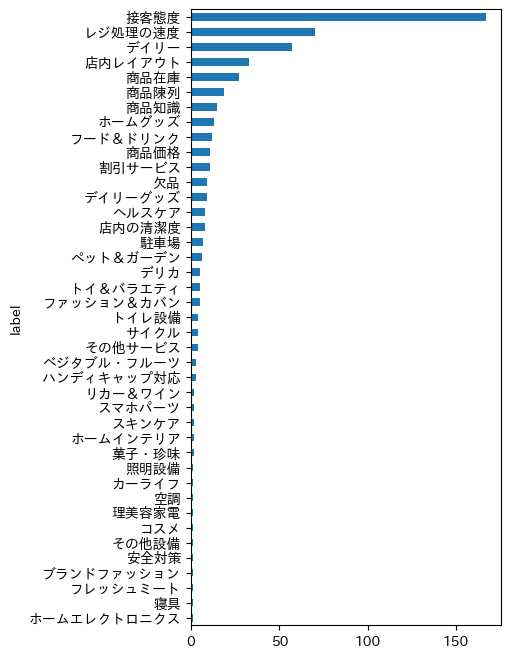

In [54]:
train_df = load_dataset('dataset_loader.py', name='category_tagging')['train'].to_pandas()
train_df['label'].map(id2tag).value_counts().sort_values().plot.barh(figsize=(4, 8))

In [63]:
_df = result_df.groupby('label').agg({'correct':'mean'})
_df.rename({'correct':'正解率'}, axis=1, inplace=True)
_df['データ件数'] = train_df['label'].map(id2tag).value_counts()

In [68]:
_df.style.background_gradient(cmap='Blues')

,正解率,データ件数
label,,
その他サービス,0.000000,4.000000
その他設備,0.000000,1.000000
カーライフ,0.000000,1.000000
スマホパーツ,0.000000,2.000000
デイリー,0.742857,57.000000
デイリーグッズ,0.500000,9.000000
デリカ,1.000000,5.000000
トイレ設備,1.000000,4.000000
ファッション＆カバン,0.000000,5.000000


In [71]:
_df.corr()

,正解率,データ件数
正解率,1.0000,0.4489
データ件数,0.4489,1.0000


相関係数は0.4489。悪くはなさそうだが、これだけが要因とは言い難い

### カテゴリーの違いが影響を及ぼしているか？

学習データに含まれるデータ件数 × カテゴリーの違いの2要因を考慮

In [75]:
_df = result_df.groupby('label').agg({'correct':'mean'})
_df.rename({'correct':'正解率'}, axis=1, inplace=True)
_df['データ件数'] = train_df['label'].map(id2tag).value_counts()
_df.reset_index(inplace=True)
_df['category'] = _df['label'].map(tag2category)
_df.style.background_gradient(cmap='Blues')

,label,正解率,データ件数,category
0,その他サービス,0.000000,4.000000,サービス・店舗
1,その他設備,0.000000,1.000000,サービス・店舗
2,カーライフ,0.000000,1.000000,商品
3,スマホパーツ,0.000000,2.000000,商品
4,デイリー,0.742857,57.000000,商品
5,デイリーグッズ,0.500000,9.000000,商品
6,デリカ,1.000000,5.000000,商品
7,トイレ設備,1.000000,4.000000,サービス・店舗
8,ファッション＆カバン,0.000000,5.000000,商品
9,フード＆ドリンク,0.333333,12.000000,商品


In [84]:
display('商品')
display(_df.query('category == "商品"')[['正解率', 'データ件数']].corr())
display('サービス・店舗')
display(_df.query('category == "サービス・店舗"')[['正解率', 'データ件数']].corr())

'商品'

,正解率,データ件数
正解率,1.0000,0.5193
データ件数,0.5193,1.0000


'サービス・店舗'

,正解率,データ件数
正解率,1.0000,0.4182
データ件数,0.4182,1.0000


商品 ＞ サービス・店舗という結果に。果たして本当だろうか。

### 外れ値が含まれているのでは

c:\Users\mak1_\Documents\Code\nlp\category_classification\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mak1_\Documents\Code\nlp\category_classification\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mak1_\Documents\Code\nlp\category_classification\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mak1_\Documents\Code\nlp\category_classification\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureW

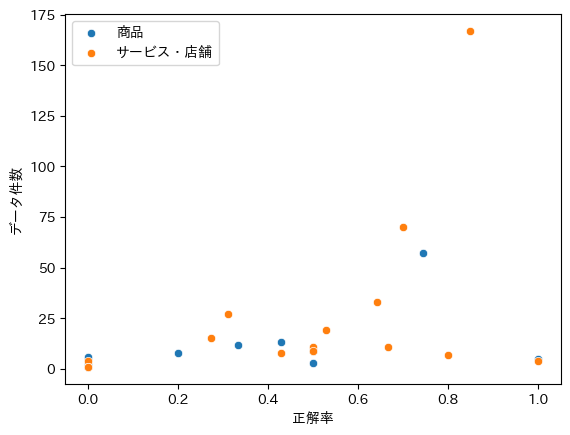

In [101]:
sns.scatterplot(data=_df.query('category == "商品"')[['正解率', 'データ件数']], x='正解率', y='データ件数')
sns.scatterplot(data=_df.query('category == "サービス・店舗"')[['正解率', 'データ件数']], x='正解率', y='データ件数')
plt.legend(['商品', 'サービス・店舗'])

いずれも飛びぬけて件数が多いものと、データ件数が微小なものとで分かれている。

方針

1. データ件数が5以下のものは対象外とする
2. 飛びぬけて件数が多いものを対象外とする

### 方針1を適用

以下を除外する

In [89]:
_df.query('データ件数 <= 5')

,label,正解率,データ件数,category
0,その他サービス,0.0000,4.0000,サービス・店舗
1,その他設備,0.0000,1.0000,サービス・店舗
2,カーライフ,0.0000,1.0000,商品
3,スマホパーツ,0.0000,2.0000,商品
6,デリカ,1.0000,5.0000,商品
7,トイレ設備,1.0000,4.0000,サービス・店舗
8,ファッション＆カバン,0.0000,5.0000,商品
11,ベジタブル・フルーツ,0.5000,3.0000,商品
13,ホームインテリア,0.0000,2.0000,商品
14,ホームエレクトロニクス,0.0000,1.0000,商品


In [109]:
product_agg_df_gt5 = _df.query('category == "商品" & データ件数 > 5')[['正解率', 'データ件数']]
service_agg_df_gt5 = _df.query('category == "サービス・店舗"& データ件数 > 5')[['正解率', 'データ件数']]

display('商品')
display(product_agg_df_gt5.corr())
display('サービス・店舗')
display(service_agg_df_gt5.corr())

'商品'

,正解率,データ件数
正解率,1.0000,0.7791
データ件数,0.7791,1.0000


'サービス・店舗'

,正解率,データ件数
正解率,1.0000,0.5426
データ件数,0.5426,1.0000


c:\Users\mak1_\Documents\Code\nlp\category_classification\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mak1_\Documents\Code\nlp\category_classification\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mak1_\Documents\Code\nlp\category_classification\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mak1_\Documents\Code\nlp\category_classification\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureW

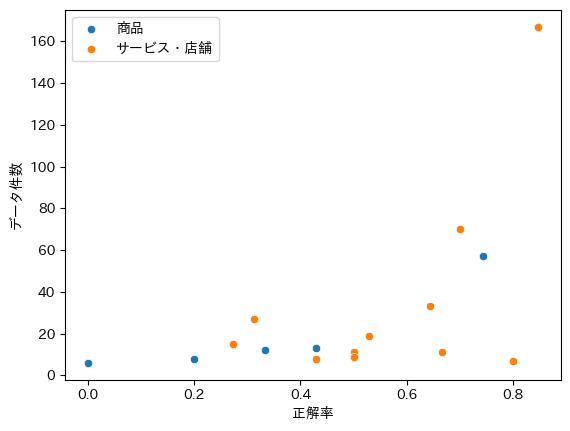

In [100]:
sns.scatterplot(data=product_agg_df_gt5, x='正解率', y='データ件数', )
sns.scatterplot(data=service_agg_df_gt5, x='正解率', y='データ件数')
plt.legend(['商品', 'サービス・店舗'])

### 方針2を適用する

In [113]:
product_agg_df_lt60 = _df.query('category == "商品" & データ件数 <= 60')[['正解率', 'データ件数']]
service_agg_df_lt100 = _df.query('category == "サービス・店舗"& データ件数 <= 100')[['正解率', 'データ件数']]

display('商品')
display(product_agg_df_lt60.corr())
display('サービス・店舗')
display(service_agg_df_lt100.corr())

'商品'

,正解率,データ件数
正解率,1.0000,0.5193
データ件数,0.5193,1.0000


'サービス・店舗'

,正解率,データ件数
正解率,1.0000,0.3188
データ件数,0.3188,1.0000


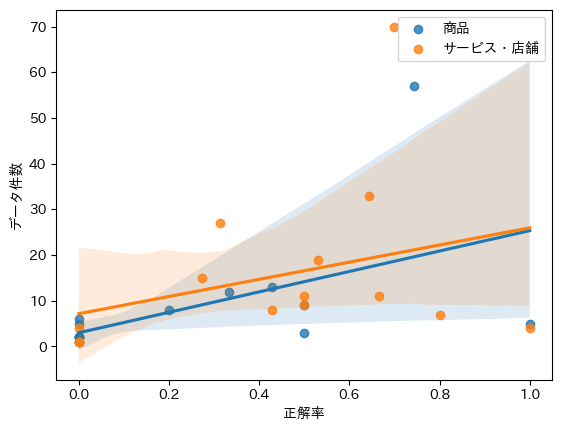

In [114]:
sns.regplot(data=product_agg_df_lt60, x='正解率', y='データ件数', label='商品')
sns.regplot(data=service_agg_df_lt100, x='正解率', y='データ件数', label='サービス・店舗')
plt.legend()

### 方針1 & 2を適用する

'商品'

,正解率,データ件数
正解率,1.0000,0.7791
データ件数,0.7791,1.0000


'サービス・店舗'

,正解率,データ件数
正解率,1.0000,0.2303
データ件数,0.2303,1.0000


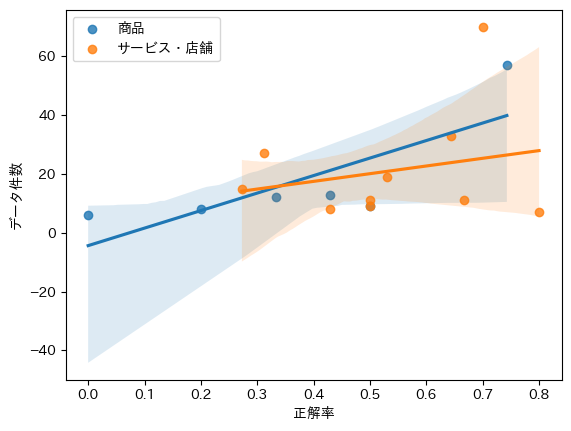

In [115]:
product_agg_df_gt5_lt60 = _df.query('category == "商品" & データ件数 > 5 & データ件数 <= 60')[['正解率', 'データ件数']]
service_agg_df_gt5_lt100 = _df.query('category == "サービス・店舗"& データ件数 > 5 & データ件数 <= 100')[['正解率', 'データ件数']]

display('商品')
display(product_agg_df_gt5_lt60.corr())
display('サービス・店舗')
display(service_agg_df_gt5_lt100.corr())

sns.regplot(data=product_agg_df_gt5_lt60, x='正解率', y='データ件数', label='商品')
sns.regplot(data=service_agg_df_gt5_lt100, x='正解率', y='データ件数', label='サービス・店舗')
plt.legend()

商品カテゴリーはデータ件数が増えれば正解率があがる、と説明ができそう。

一方、サービス・店舗は正解率に影響する別の要因があると思われる。